# User Wise Hybrid

In [1]:
from Utils.Toolkit import get_data

data = get_data()

URM = data['train'].tocsr()
ICM = data['ICM_subclass'].tocsr()

## Let's divide users intro groups

In [2]:
import numpy as np

group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
group5 = []
group6 = []
group7 = []
group8 = []
group9 = []

for user_id in range(URM.shape[0]):
    start_pos = URM.indptr[user_id]
    end_pos = URM.indptr[user_id + 1]
    if len(URM.data[start_pos:end_pos]) == 0:
        group0.append(user_id)
    elif 0 < len(URM.data[start_pos:end_pos]) <= 2:
        group1.append(user_id)
    elif 2 < len(URM.data[start_pos:end_pos]) <= 5:
        group2.append(user_id)
    elif 5 < len(URM.data[start_pos:end_pos]) <= 10:
        group3.append(user_id)
    elif 10 < len(URM.data[start_pos:end_pos]) <= 20:
        group4.append(user_id)
    elif 20 < len(URM.data[start_pos:end_pos]) <= 30:
        group5.append(user_id)
    elif 40 < len(URM.data[start_pos:end_pos]) <= 60:
        group6.append(user_id)
    elif 60 < len(URM.data[start_pos:end_pos]) <= 100:
        group7.append(user_id)
    elif 100 < len(URM.data[start_pos:end_pos]) <= 300:
        group8.append(user_id)
    elif 300 < len(URM.data[start_pos:end_pos]) <= 10000:
        group9.append(user_id)

        
group0 = np.array(group0)
group1 = np.array(group1)
group2 = np.array(group2)
group3 = np.array(group3)
group4 = np.array(group4)
group5 = np.array(group5)
group6 = np.array(group6)
group7 = np.array(group7)
group8 = np.array(group8)
group9 = np.array(group9)

group = np.array([group0, group1, group2, group3, group4, group5, group6, group7, group8, group9])

In [3]:
print(str(len(group0)) + " Cold users")
print(len(group1))
print(len(group2))
print(len(group3))
print(len(group4))
print(len(group5))
print(len(group6))
print(len(group7))
print(len(group8))
print(len(group9))

6473 Cold users
3695
4556
5034
5443
2502
1183
530
131
5


In [4]:
from Recommenders.HYB.hybrid import HybridRecommender

userCF_args = {
        'topK' : 102,
        'shrink' : 7
}

userCBF_args = {
    'topK' : 1000,
    'shrink' : 7950
}

itemCF_args = {
    'topK' : 29,
    'shrink' : 5
}
itemCBF_args = {
    'topK' : 29,
    'shrink' : 5
}

SLIM_BPR_args = {
    'topK': 20,
    'lambda_i': 5.0,
    'lambda_j': 7.0,
    'epochs': 5000,
    'learning_rate' : 1e-4,
    'symmetric' : True,
    'sgd_mode' : 'adam'
}

weights_initial = {
    'user_cf' : 0,
    'item_cf' : 1.55,
    'SLIM_BPR' : 1.62,
    'item_cbf' : 0,
    'ALS' : 0.6
}

weights_middle = {
    'user_cf' : 0,
    'item_cf' : 1.55,
    'SLIM_BPR' : 1.52,
    'item_cbf' : 0,
    'ALS' : 0.6
}

weights_end = {
    'user_cf' : 0,
    'item_cf' : 1.55,
    'SLIM_BPR' : 0,
    'item_cbf' : 0,
    'ALS' : 0.3
}

hyb = HybridRecommender(weights=[weights_initial, weights_middle, weights_end],
                            userCF_args=userCF_args,
                            SLIM_BPR_args=SLIM_BPR_args,
                            itemCF_args=itemCF_args,
                            itemCBF_args=itemCBF_args,
                            userCBF_args=userCBF_args)

hyb.fit(URM, ICM, data['UCM'].tocsr())

Fitting ItemCF...
Fitting UserCBF...
Fitting SLIM...


Fitting ALS...



Done fitting models...


In [5]:
from Recommenders.CF.FeatureBoostedItemCollaborative import FeatureBoostedItemCollaborativeFiltering
from Recommenders.CF.item_cf import ItemBasedCollaborativeFiltering
from Recommenders.CF.user_cf import UserBasedCollaborativeFiltering
from Recommenders.CBF.user_CBF import UserContentBasedRecommender
from Recommenders.CBF.item_CBF import ItemContentBasedRecommender
from Recommenders.SLIM.SLIM_BPR_Cython import SLIM_BPR_Cython

itemCF = ItemBasedCollaborativeFiltering(29, 5)
itemCF.fit(URM.copy())

userCBF = UserContentBasedRecommender(1000, 7900)
userCBF.fit(URM.copy(), data['UCM'])

userCF = UserBasedCollaborativeFiltering(94, 19)
userCF.fit(URM.copy())

itemCBF = ItemContentBasedRecommender(100, 5)
itemCBF.fit(URM.copy(), ICM)



slim = SLIM_BPR_Cython(epochs=5000,
                               topK=20,
                               lambda_i=1.0,
                               lambda_j=7.0,
                               positive_threshold=1,
                               sgd_mode="adam",
                               symmetric=False,
                               learning_rate=1e-4)

slim.fit(URM.copy())

In [6]:
MAPs_ICF = []
MAPs_UCBF = []
MAPs_ICBF = []
MAPs_UCF = []
MAPs_slim = []
MAPs_hyb = []

for group_id in range(len(group)):
    
    result = itemCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICF.append(result['MAP'])
    
    result = userCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCBF.append(result['MAP'])
    
    result = itemCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICBF.append(result['MAP'])
    
    result = userCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCF.append(result['MAP'])
    
    result = slim.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_slim.append(result['MAP'])
    
    result = hyb.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_hyb.append(result['MAP'])

Evaluating MAP with target:   3%|▎         | 168/6473 [00:00<00:03, 1679.41it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   5%|▌         | 324/6473 [00:00<00:01, 3231.27it/s]

UserContentBasedRecommender -> MAP: 0.0014	TOTAL MISS=2695	Relevant=122


Evaluating MAP with target:   5%|▍         | 322/6473 [00:00<00:01, 3218.55it/s]

ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   5%|▌         | 327/6473 [00:00<00:01, 3269.25it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   1%|▏         | 89/6473 [00:00<00:07, 882.82it/s]

BaseRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   3%|▎         | 121/3695 [00:00<00:02, 1208.71it/s]

HYB -> MAP: 0.0014	TOTAL MISS=2695	Relevant=122


Evaluating MAP with target:   2%|▏         | 71/3695 [00:00<00:05, 707.73it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0067	TOTAL MISS=3383	Relevant=312


Evaluating MAP with target:   3%|▎         | 126/3695 [00:00<00:02, 1259.08it/s]

UserContentBasedRecommender -> MAP: 0.0013	TOTAL MISS=3571	Relevant=124


Evaluating MAP with target:   3%|▎         | 106/3695 [00:00<00:03, 1056.17it/s]

ItemContentBasedRecommender -> MAP: 0.0007	TOTAL MISS=3641	Relevant=54


Evaluating MAP with target:   4%|▍         | 141/3695 [00:00<00:02, 1400.13it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0065	TOTAL MISS=3348	Relevant=347


Evaluating MAP with target:   1%|          | 40/3695 [00:00<00:09, 393.63it/s]

BaseRecommender -> MAP: 0.0063	TOTAL MISS=3383	Relevant=312


Evaluating MAP with target:   5%|▌         | 239/4556 [00:00<00:03, 1189.47it/s]

HYB -> MAP: 0.0072	TOTAL MISS=3322	Relevant=373


Evaluating MAP with target:   3%|▎         | 140/4556 [00:00<00:06, 696.78it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0085	TOTAL MISS=4093	Relevant=463


Evaluating MAP with target:   3%|▎         | 130/4556 [00:00<00:03, 1291.92it/s]

UserContentBasedRecommender -> MAP: 0.0018	TOTAL MISS=4396	Relevant=160


Evaluating MAP with target:   5%|▌         | 230/4556 [00:00<00:03, 1138.70it/s]

ItemContentBasedRecommender -> MAP: 0.0008	TOTAL MISS=4494	Relevant=62


Evaluating MAP with target:   3%|▎         | 135/4556 [00:00<00:03, 1346.63it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0054	TOTAL MISS=4232	Relevant=324


Evaluating MAP with target:   1%|          | 41/4556 [00:00<00:11, 405.64it/s]

BaseRecommender -> MAP: 0.0073	TOTAL MISS=4140	Relevant=416


Evaluating MAP with target:   2%|▏         | 113/5034 [00:00<00:04, 1125.86it/s]

HYB -> MAP: 0.0087	TOTAL MISS=4055	Relevant=501


Evaluating MAP with target:   3%|▎         | 138/5034 [00:00<00:07, 690.51it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0094	TOTAL MISS=4486	Relevant=548


Evaluating MAP with target:   2%|▏         | 120/5034 [00:00<00:04, 1196.90it/s]

UserContentBasedRecommender -> MAP: 0.0016	TOTAL MISS=4880	Relevant=154


Evaluating MAP with target:   5%|▍         | 230/5034 [00:00<00:04, 1141.39it/s]

ItemContentBasedRecommender -> MAP: 0.0011	TOTAL MISS=4958	Relevant=76


Evaluating MAP with target:   5%|▌         | 257/5034 [00:00<00:03, 1280.48it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0043	TOTAL MISS=4785	Relevant=249


Evaluating MAP with target:   2%|▏         | 84/5034 [00:00<00:11, 415.23it/s]

BaseRecommender -> MAP: 0.0079	TOTAL MISS=4555	Relevant=479


Evaluating MAP with target:   4%|▍         | 212/5443 [00:00<00:04, 1047.87it/s]

HYB -> MAP: 0.0095	TOTAL MISS=4474	Relevant=560


Evaluating MAP with target:   1%|          | 65/5443 [00:00<00:08, 638.28it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0096	TOTAL MISS=4847	Relevant=596


Evaluating MAP with target:   2%|▏         | 115/5443 [00:00<00:04, 1143.24it/s]

UserContentBasedRecommender -> MAP: 0.0014	TOTAL MISS=5304	Relevant=139


Evaluating MAP with target:   4%|▍         | 219/5443 [00:00<00:04, 1080.19it/s]

ItemContentBasedRecommender -> MAP: 0.0007	TOTAL MISS=5384	Relevant=59


Evaluating MAP with target:   2%|▏         | 117/5443 [00:00<00:04, 1161.90it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0030	TOTAL MISS=5260	Relevant=183


Evaluating MAP with target:   1%|          | 34/5443 [00:00<00:16, 337.83it/s]

BaseRecommender -> MAP: 0.0080	TOTAL MISS=4963	Relevant=480


Evaluating MAP with target:   7%|▋         | 186/2502 [00:00<00:02, 926.57it/s]

HYB -> MAP: 0.0096	TOTAL MISS=4836	Relevant=607


Evaluating MAP with target:   2%|▏         | 57/2502 [00:00<00:04, 566.90it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0034	TOTAL MISS=2275	Relevant=227


Evaluating MAP with target:   4%|▍         | 98/2502 [00:00<00:02, 971.49it/s]

UserContentBasedRecommender -> MAP: 0.0006	TOTAL MISS=2447	Relevant=55


Evaluating MAP with target:   4%|▍         | 99/2502 [00:00<00:02, 986.23it/s]

ItemContentBasedRecommender -> MAP: 0.0003	TOTAL MISS=2478	Relevant=24


Evaluating MAP with target:   4%|▍         | 98/2502 [00:00<00:02, 978.73it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0006	TOTAL MISS=2462	Relevant=40


Evaluating MAP with target:   2%|▏         | 38/2502 [00:00<00:06, 375.42it/s]

BaseRecommender -> MAP: 0.0026	TOTAL MISS=2319	Relevant=183


Evaluating MAP with target:   6%|▌         | 70/1183 [00:00<00:01, 699.95it/s]

HYB -> MAP: 0.0033	TOTAL MISS=2274	Relevant=228


Evaluating MAP with target:   4%|▎         | 42/1183 [00:00<00:02, 419.66it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0012	TOTAL MISS=1084	Relevant=99


Evaluating MAP with target:   7%|▋         | 77/1183 [00:00<00:01, 767.28it/s]

UserContentBasedRecommender -> MAP: 0.0002	TOTAL MISS=1160	Relevant=23


Evaluating MAP with target:  12%|█▏        | 144/1183 [00:00<00:01, 711.64it/s]

ItemContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=1172	Relevant=11


Evaluating MAP with target:  13%|█▎        | 157/1183 [00:00<00:01, 781.84it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0001	TOTAL MISS=1171	Relevant=12


Evaluating MAP with target:   3%|▎         | 41/1183 [00:00<00:02, 402.93it/s]

BaseRecommender -> MAP: 0.0009	TOTAL MISS=1114	Relevant=69


Evaluating MAP with target:  12%|█▏        | 65/530 [00:00<00:00, 649.27it/s]

HYB -> MAP: 0.0012	TOTAL MISS=1082	Relevant=101


Evaluating MAP with target:   8%|▊         | 40/530 [00:00<00:01, 389.84it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0005	TOTAL MISS=500	Relevant=30


Evaluating MAP with target:  29%|██▉       | 153/530 [00:00<00:00, 744.81it/s]

UserContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=518	Relevant=12


Evaluating MAP with target:  13%|█▎        | 70/530 [00:00<00:00, 698.75it/s]

ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=527	Relevant=3


Evaluating MAP with target:  13%|█▎        | 68/530 [00:00<00:00, 674.69it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=528	Relevant=2


Evaluating MAP with target:   8%|▊         | 42/530 [00:00<00:01, 413.16it/s]

BaseRecommender -> MAP: 0.0004	TOTAL MISS=503	Relevant=27


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

HYB -> MAP: 0.0005	TOTAL MISS=496	Relevant=34
ItemBasedCollaborativeFiltering -> MAP: 0.0001	TOTAL MISS=124	Relevant=7


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=129	Relevant=2
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=130	Relevant=1


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=131	Relevant=0
BaseRecommender -> MAP: 0.0001	TOTAL MISS=126	Relevant=5


Evaluating MAP with target: 100%|██████████| 5/5 [00:00<00:00, 322.14it/s]

HYB -> MAP: 0.0001	TOTAL MISS=124	Relevant=7
ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
BaseRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
HYB -> MAP: 0.0000	TOTAL MISS=5	Relevant=0


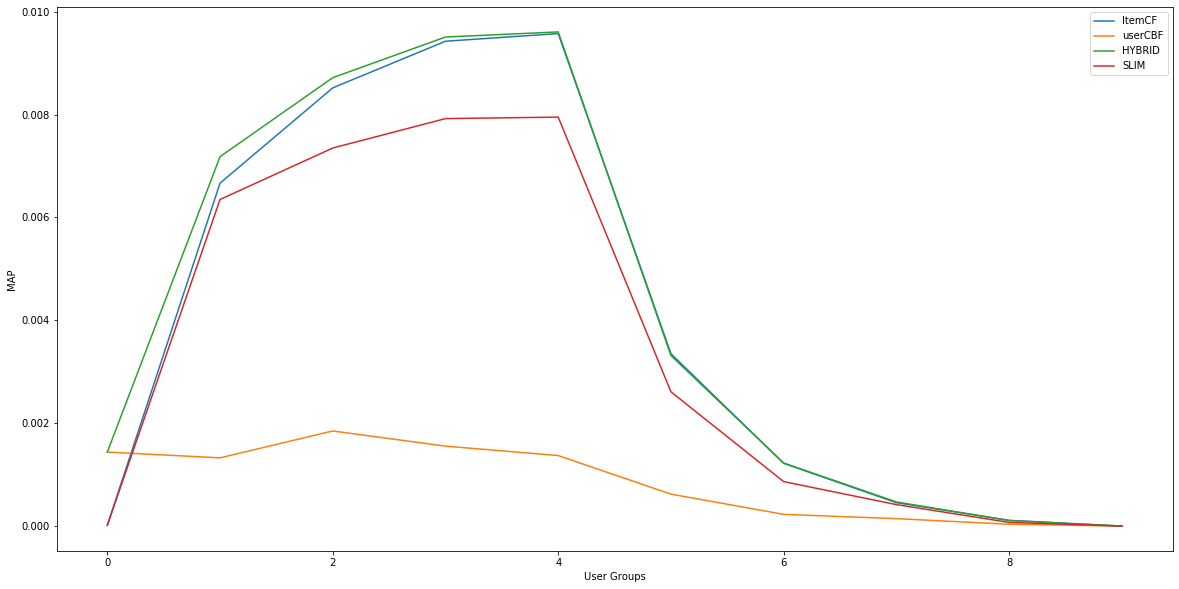

In [7]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.figure(figsize=(20,10))
pyplot.plot(MAPs_ICF, label="ItemCF")
pyplot.plot(MAPs_UCBF, label="userCBF")
pyplot.plot(MAPs_hyb, label="HYBRID")
pyplot.plot(MAPs_slim, label="SLIM")
pyplot.ylabel('MAP')
pyplot.xlabel('User Groups')
pyplot.legend()
pyplot.show()

# UserCBF tuning for cold users

In [ ]:
from Utils.Toolkit import get_URM_TFIDF

MAP_topK = []
MAP_shrink = []
for shrink in [7950, 7960]:
    userCBF = UserContentBasedRecommender(10300, shrink)
    UCM = data['UCM']
    UCM = get_URM_TFIDF(UCM)
    userCBF.fit(URM.copy(), UCM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()

# ItemCBF tuning

In [ ]:
MAP_topK = []
for topK in [5, 10, 30, 50, 100, 200, 400, 700, 1000]:
    itemCBF = ItemContentBasedRecommender(topK, 5)
    itemCBF.fit(URM.copy(), ICM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()